# Experiment 2: BOW + LDA + LR

In [1]:
#imports
#import warnings
#warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/elenaruiz/Documents/FNC')
import pandas as pd
import numpy as np
from src.utils import io
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

## Import dataset

In [2]:
articles = io.read_json_file('/home/elenaruiz/Documents/FNC/src/data/dataset_raw.json')
df = pd.DataFrame(data=articles['articles'])

In [3]:
df.head()

,all_sent,all_word,fake,subtitle_sent,subtitle_word,text_joined,text_paragraph,text_sent,text_word,title_sent,title_word
0,[find corpse vegetarian restaurant Bangkok The...,"[find, corpse, vegetarian, restaurant, Bangkok...",True,[find corpse vegetarian restaurant Bangkok],"[find, corpse, vegetarian, restaurant, Bangkok]",The Thai police have clarified to the middle A...,[Thai police clarify middle Asians meat man ki...,[Thai police clarify middle Asians meat man ki...,"[Thai, police, clarify, middle, Asians, meat, ...",[find corpse vegetarian restaurant Bangkok],"[find, corpse, vegetarian, restaurant, Bangkok]"
1,[switzerland warn authorize extradition politi...,"[switzerland, warn, authorize, extradition, po...",True,[switzerland warn authorize extradition politi...,"[switzerland, warn, authorize, extradition, po...","The Swiss government has said Tuesday that ""a ...",[Swiss government say Tuesday priori case lead...,[Swiss government say Tuesday priori case lead...,"[Swiss, government, say, Tuesday, priori, case...",[switzerland warn authorize extradition politi...,"[switzerland, warn, authorize, extradition, po..."
2,[navarre censor Songs Amaral Shakira song Madm...,"[navarre, censor, Songs, Amaral, Shakira, song...",True,[navarre censor Songs Amaral Shakira song Madm...,"[navarre, censor, Songs, Amaral, Shakira, song...","The Government of Navarra, within the Skolae p...",[Government Navarra within Skolae program prom...,[Government Navarra within Skolae program prom...,"[Government, Navarra, within, Skolae, program,...",[navarre censor Songs Amaral Shakira song Madm...,"[navarre, censor, Songs, Amaral, Shakira, song..."
3,[woman pretend blind years greet people Now tr...,"[woman, pretend, blind, years, greet, people, ...",True,[woman pretend blind years greet people],"[woman, pretend, blind, years, greet, people]",Carmen Jiménez told her family and friends 28 ...,[carmen Jiménez tell family friends years ago ...,[carmen Jiménez tell family friends years ago ...,"[carmen, Jiménez, tell, family, friends, years...",[woman pretend blind years greet people],"[woman, pretend, blind, years, greet, people]"
4,[arrested ejaculate boss coffee last four year...,"[arrested, ejaculate, boss, coffee, last, four...",True,[arrested ejaculate boss coffee last four years],"[arrested, ejaculate, boss, coffee, last, four...","Lewis Williams, a worker at an engineering fir...",[lewis Williams worker engineer firm Newark Un...,[lewis Williams worker engineer firm Newark Un...,"[lewis, Williams, worker, engineer, firm, Newa...",[arrested ejaculate boss coffee last four years],"[arrested, ejaculate, boss, coffee, last, four..."


## 1. BOW Encoding

In [4]:
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax

In [5]:
from src.fake_news_detector.core.encoders import bow

corpus, dictionary = bow.bow_encoding(list(df['all_word']), 0.6, 2)
bow.print_size(dictionary)


Found 2069 words.


In [6]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)
cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

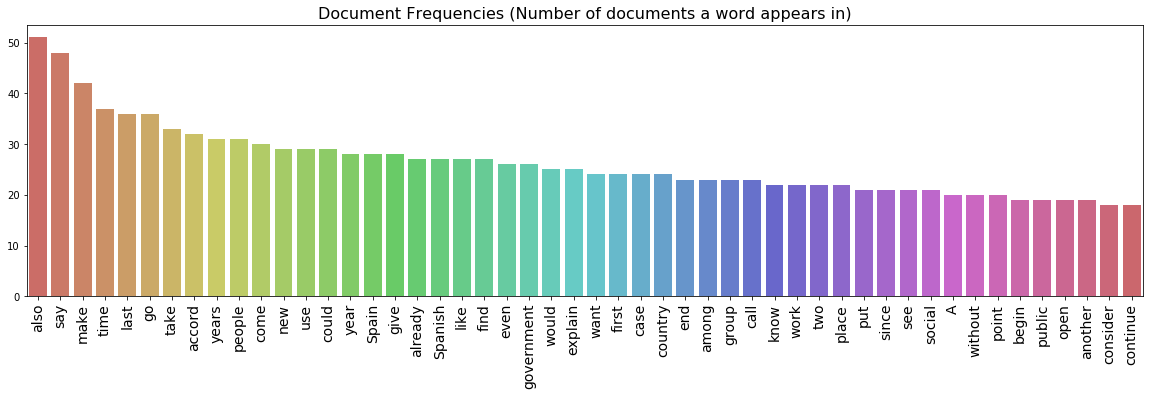

In [7]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

In [17]:
import itertools
fake_dataset = df.loc[df['fake'] == True]
real_dataset = df.loc[df['fake'] == False]
FAKE_news_words = list(itertools.chain.from_iterable(list(fake_dataset['all_word'])))
REAL_news_words = list(itertools.chain.from_iterable(list(real_dataset['all_word'])))

In [19]:
FAKE_news_words_frequencies = {word: FAKE_news_words.count(word) for word in cleansed_words_df.index[:50]}
REAL_news_words_frequencies = {word: REAL_news_words.count(word) for word in cleansed_words_df.index[:50]}

In [21]:
frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

In [22]:
frequencies_df['True_freq'] = list(map(lambda word:
                                      REAL_news_words_frequencies[word],
                                      frequencies_df.index))
frequencies_df['Fake_freq'] = list(map(lambda word:
                                          FAKE_news_words_frequencies[word] + REAL_news_words_frequencies[word],
                                          frequencies_df.index))

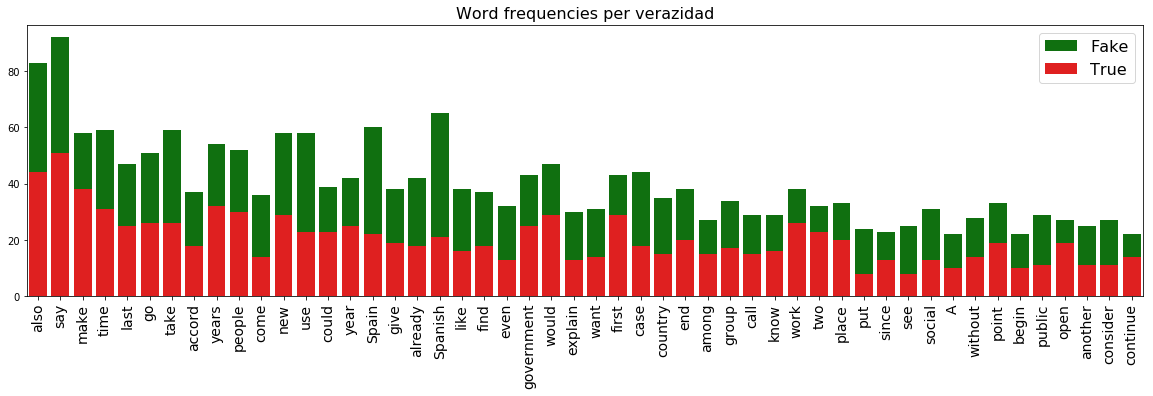

In [23]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))
sns.barplot(nrs, frequencies_df['Fake_freq'].values, color='g', ax=ax, label="Fake")
sns.barplot(nrs, frequencies_df['True_freq'].values, color='r', ax=ax, label="True")

ax.set_title("Word frequencies per verazidad", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

## 2. LDA

In [28]:
from src.fake_news_detector.core.classificators import LDA_text as lt

lda_model = lt.create_LDA(corpus, dictionary, 5)
lt.print_top_words(lda_model)

Topic: 0 
Words: 0.007*"say" + 0.005*"also" + 0.005*"European" + 0.004*"year" + 0.004*"people" + 0.004*"would" + 0.004*"make" + 0.004*"case" + 0.004*"family" + 0.004*"could"
Topic: 1 
Words: 0.009*"say" + 0.009*"Spain" + 0.006*"time" + 0.006*"would" + 0.005*"also" + 0.005*"first" + 0.005*"end" + 0.005*"government" + 0.005*"point" + 0.004*"new"
Topic: 2 
Words: 0.008*"Spanish" + 0.007*"take" + 0.005*"police" + 0.004*"say" + 0.004*"already" + 0.004*"make" + 0.004*"people" + 0.004*"euros" + 0.004*"like" + 0.004*"case"
Topic: 3 
Words: 0.008*"use" + 0.006*"also" + 0.006*"take" + 0.006*"years" + 0.005*"Madrid" + 0.005*"go" + 0.005*"say" + 0.004*"Spanish" + 0.004*"new" + 0.004*"people"
Topic: 4 
Words: 0.007*"also" + 0.005*"new" + 0.005*"Spanish" + 0.005*"attack" + 0.005*"use" + 0.004*"make" + 0.004*"say" + 0.004*"last" + 0.004*"euros" + 0.004*"government"
